## Extractive Summarization - Pytorch

In this notebook, we provide an implementation for training an extractive text summarization model. The overall goal is to "score" each sentence in a passage where the score represents the likelihood that the sentence belongs in a summary.


## Dataset

We will use the CNN/Dailymail dataset (contains articles and human written highlights) which has been preprocessed in the following way

- Each sentence in each article (extracted using a large Spacy LM) is assigned a label (0: not in summary, 1: in summary). Since CNN/DailyMail highlights dont contain exact extracts, the label is generatedd based on max Rogue score between sentence and each sentence in highlights. See data preprocesssing notebook for details.
- Data is undersampled to reduce class imbalance 

## Problem Formulation and Model 

We treat this as a sentence classification problem where the goal is to classify each sentence in a document as belonging to a summary or not, given the document (or portions of the document) 

- Model Input: a sentence, and the entire document 
- Model Output: A score representing likelihood of belonging in the summary or not. 

## Implementation 

- We use sentence bert models to get representations for our text. We use the smallest model (sentence-transformers/paraphrase-MiniLM-L3-v2), but this can be replaced by a larger more accurate model. See the list of sentence bert pretrained  [models](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models).
- Representations for sentence and document are concatenated and fed to a Dense layer and then predictions.

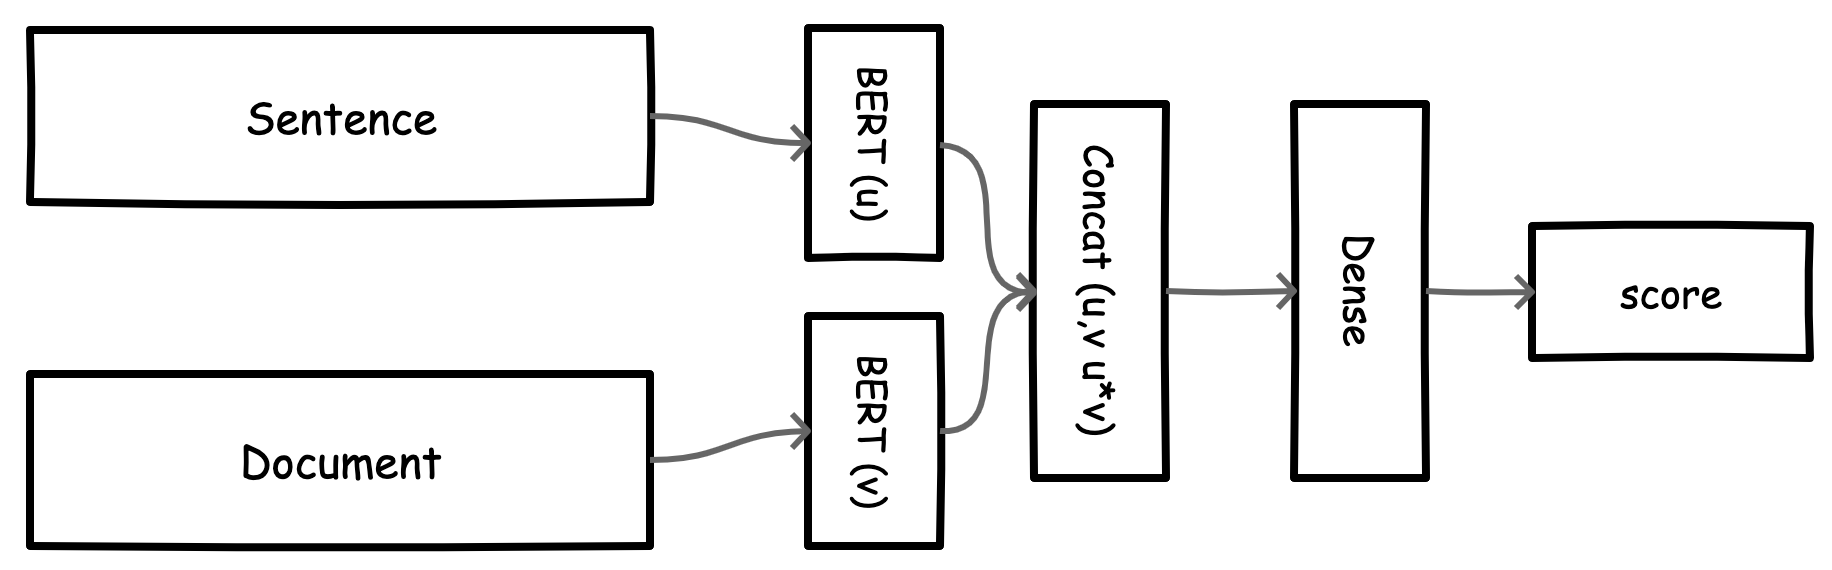

In [1]:
!pip install -q transformers  rouge-score  

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
 
import pandas as pd 
import transformers
from torch.utils.data import Dataset, DataLoader 


from transformers import AutoTokenizer, AutoModel
sentenc_model_name = "sentence-transformers/paraphrase-MiniLM-L3-v2"
tokenizer = AutoTokenizer.from_pretrained(sentenc_model_name) 


Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [3]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from tqdm.notebook import tqdm
 
import os 
  
sum_dir = "./kaggle/input" # location to store and load models 

In [4]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-10

# load dataframes containining preprocessed samples from CNN/Dailymail Dataset
train_df = pd.read_json("/kaggle/input/processed-cnn-data/data/train/train_bdf.json")

train_df = train_df.iloc[:len(train_df) // 8, :]

test_df = pd.read_json("/kaggle/input/processed-cnn-data/data/test/test_bdf.json") 
print( "Train, test shape", train_df.shape, test_df.shape)

Train, test shape (85354, 3) (33297, 3)


## Create a Data Loader Class 

- Create a dataloader class that yields sentences and documentss and labels.

In [5]:

# Create a Data Loader Class
class CNNDailyMailData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        sentence = str(self.data.iloc[index].sents)
        sentence = " ".join(sentence.split())

        document = str(self.data.iloc[index].docs)
        document = " ".join(document.split())

        inputs = self.tokenizer.batch_encode_plus(
            [sentence, document], 
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'sent_ids': torch.tensor(ids[0], dtype=torch.long),
            'doc_ids': torch.tensor(ids[1], dtype=torch.long),
            'sent_mask': torch.tensor(mask[0], dtype=torch.long),
            'doc_mask': torch.tensor(mask[1], dtype=torch.long),
            'targets': torch.tensor([self.data.iloc[index].y], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len



training_set = CNNDailyMailData(train_df, tokenizer, MAX_LEN)
testing_set = CNNDailyMailData(test_df, tokenizer, MAX_LEN)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)        

## Build Model 

- Build model based on sentence Bert pretrained models.

In [6]:
# get mean pooling for sentence bert models 
# ref https://www.sbert.net/examples/applications/computing-embeddings/README.html#sentence-embeddings-with-transformers
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask


# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Note that different sentence transformer models may have different in_feature sizes
class SentenceBertClass(torch.nn.Module):
    def __init__(self, model_name="sentence-transformers/paraphrase-MiniLM-L3-v2", in_features=384):
        super(SentenceBertClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_name)
        self.pre_classifier = torch.nn.Linear(in_features*3, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 1)
        self.classifierSigmoid = torch.nn.Sigmoid()

    def forward(self, sent_ids, doc_ids, sent_mask, doc_mask):

        sent_output = self.l1(input_ids=sent_ids, attention_mask=sent_mask) 
        sentence_embeddings = mean_pooling(sent_output, sent_mask) 

        doc_output = self.l1(input_ids=doc_ids, attention_mask=doc_mask) 
        doc_embeddings = mean_pooling(doc_output, doc_mask)

        # elementwise product of sentence embs and doc embs
        combined_features = sentence_embeddings * doc_embeddings  

        # Concatenate input features and their elementwise product
        concat_features = torch.cat((sentence_embeddings, doc_embeddings, combined_features), dim=1)   
        
        pooler = self.pre_classifier(concat_features) 
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.classifierSigmoid(output) 

        return output

In [7]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

model = SentenceBertClass(model_name=sentenc_model_name)
model.to(device);

loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Downloading:   0%|          | 0.00/66.4M [00:00<?, ?B/s]

In [8]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model
print_n_steps = 1000
acc_step_holder, loss_step_holder = [], []


def train(epoch):    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        sent_ids = data['sent_ids'].to(device, dtype = torch.long)
        doc_ids = data['doc_ids'].to(device, dtype = torch.long)
        sent_mask = data['sent_mask'].to(device, dtype = torch.long)
        doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
        targets = data['targets'].to(device, dtype = torch.float)  

        outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
        loss = loss_function(outputs, targets)
        tr_loss += loss.item() 
        n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%print_n_steps==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(str(_* train_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)
            acc_step_holder.append(accu_step), loss_step_holder.append(loss_step)
        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [9]:
for epoch in range(EPOCHS):
    train(epoch)

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 50.0 Loss -> 0.6893056631088257
4000/85354 - Steps. Acc -> 63.061938061938065 Loss -> 0.6883091369828025
8000/85354 - Steps. Acc -> 62.85607196401799 Loss -> 0.6884266504462155
12000/85354 - Steps. Acc -> 63.32055981339553 Loss -> 0.6883008194859526
16000/85354 - Steps. Acc -> 63.29042739315171 Loss -> 0.6882899476867472
20000/85354 - Steps. Acc -> 63.19736052789442 Loss -> 0.6882592673731718
24000/85354 - Steps. Acc -> 63.11448091984669 Loss -> 0.6882986057164212
28000/85354 - Steps. Acc -> 62.912441079845735 Loss -> 0.688335505685982
32000/85354 - Steps. Acc -> 63.004624421947256 Loss -> 0.6883347442769628
36000/85354 - Steps. Acc -> 63.031885346072656 Loss -> 0.6883295340652453
40000/85354 - Steps. Acc -> 63.023697630236974 Loss -> 0.6883443832552417
44000/85354 - Steps. Acc -> 62.982910644486864 Loss -> 0.6883708274469583
48000/85354 - Steps. Acc -> 63.036413632197316 Loss -> 0.6883550710742071
52000/85354 - Steps. Acc -> 63.04899623105915 Loss -> 0.68835356

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 75.0 Loss -> 0.6836354732513428
4000/85354 - Steps. Acc -> 62.28771228771229 Loss -> 0.6884157976785025
8000/85354 - Steps. Acc -> 62.31884057971015 Loss -> 0.6884665418600572
12000/85354 - Steps. Acc -> 62.48750416527824 Loss -> 0.6884345893103534
16000/85354 - Steps. Acc -> 62.77180704823794 Loss -> 0.6884270895126312
20000/85354 - Steps. Acc -> 62.63247350529894 Loss -> 0.6884575974247594
24000/85354 - Steps. Acc -> 62.58956840526579 Loss -> 0.6884688399986632
28000/85354 - Steps. Acc -> 62.69461505499214 Loss -> 0.6884564308162554
32000/85354 - Steps. Acc -> 62.8265216847894 Loss -> 0.6884273539079963
36000/85354 - Steps. Acc -> 62.91800911009888 Loss -> 0.6884070734635497
40000/85354 - Steps. Acc -> 63.06869313068693 Loss -> 0.6883603256650596
44000/85354 - Steps. Acc -> 63.13062448868285 Loss -> 0.6883340266420347
48000/85354 - Steps. Acc -> 63.203066411132404 Loss -> 0.6883033260823528
52000/85354 - Steps. Acc -> 63.33743558187832 Loss -> 0.68827994385918

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 100.0 Loss -> 0.6849666833877563
4000/85354 - Steps. Acc -> 62.96203796203796 Loss -> 0.6884778917252601
8000/85354 - Steps. Acc -> 63.65567216391804 Loss -> 0.6882142147560348
12000/85354 - Steps. Acc -> 63.99533488837054 Loss -> 0.6880612626785996
16000/85354 - Steps. Acc -> 64.07148212946764 Loss -> 0.6880321951843268
20000/85354 - Steps. Acc -> 64.09218156368726 Loss -> 0.6880610839316093
24000/85354 - Steps. Acc -> 63.9643392767872 Loss -> 0.6880657423875507
28000/85354 - Steps. Acc -> 63.85516354806456 Loss -> 0.6880520646648055
32000/85354 - Steps. Acc -> 63.804524434445696 Loss -> 0.688071459893092
36000/85354 - Steps. Acc -> 63.75958226863682 Loss -> 0.6880908350377146
40000/85354 - Steps. Acc -> 63.55864413558644 Loss -> 0.6881722676349918
44000/85354 - Steps. Acc -> 63.55331333515135 Loss -> 0.6881530361385326
48000/85354 - Steps. Acc -> 63.544704607949335 Loss -> 0.6881627646518463
52000/85354 - Steps. Acc -> 63.545111914468116 Loss -> 0.688170805567

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 50.0 Loss -> 0.690235435962677
4000/85354 - Steps. Acc -> 64.31068931068931 Loss -> 0.6880140299206371
8000/85354 - Steps. Acc -> 64.5552223888056 Loss -> 0.6879596429905375
12000/85354 - Steps. Acc -> 63.395534821726095 Loss -> 0.6882380016721594
16000/85354 - Steps. Acc -> 63.50287428142964 Loss -> 0.6882338704868604
20000/85354 - Steps. Acc -> 63.54229154169166 Loss -> 0.688250559684015
24000/85354 - Steps. Acc -> 63.58106982169638 Loss -> 0.6882536071893514
28000/85354 - Steps. Acc -> 63.558777317526065 Loss -> 0.6882307288681093
32000/85354 - Steps. Acc -> 63.51393575803024 Loss -> 0.6881994262082534
36000/85354 - Steps. Acc -> 63.62904121764248 Loss -> 0.6881797617242782
40000/85354 - Steps. Acc -> 63.556144385561446 Loss -> 0.6881907652013481
44000/85354 - Steps. Acc -> 63.5624034178711 Loss -> 0.6881789098857869
48000/85354 - Steps. Acc -> 63.46346137821848 Loss -> 0.6881959085046883
52000/85354 - Steps. Acc -> 63.5412660564572 Loss -> 0.6881770317659553

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 25.0 Loss -> 0.6964045763015747
4000/85354 - Steps. Acc -> 63.23676323676324 Loss -> 0.6884857735314688
8000/85354 - Steps. Acc -> 63.69315342328836 Loss -> 0.6883545370175802
12000/85354 - Steps. Acc -> 63.77874041986005 Loss -> 0.6882241248131116
16000/85354 - Steps. Acc -> 63.77780554861285 Loss -> 0.6881459766970489
20000/85354 - Steps. Acc -> 63.8122375524895 Loss -> 0.6881424928040438
24000/85354 - Steps. Acc -> 63.910181636393936 Loss -> 0.688167214641927
28000/85354 - Steps. Acc -> 64.00871304099414 Loss -> 0.6881294366104775
32000/85354 - Steps. Acc -> 64.05449318835146 Loss -> 0.6881257698113077
36000/85354 - Steps. Acc -> 63.970669925563826 Loss -> 0.6881572287846321
40000/85354 - Steps. Acc -> 63.98110188981102 Loss -> 0.688120698478267
44000/85354 - Steps. Acc -> 63.987364785019544 Loss -> 0.6881342290824202
48000/85354 - Steps. Acc -> 63.9905007916007 Loss -> 0.6881293853504759
52000/85354 - Steps. Acc -> 63.8623952003692 Loss -> 0.6881522587946438

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 50.0 Loss -> 0.6921231150627136
4000/85354 - Steps. Acc -> 63.43656343656344 Loss -> 0.6882842963749355
8000/85354 - Steps. Acc -> 63.14342828585707 Loss -> 0.6882876897978223
12000/85354 - Steps. Acc -> 63.68710429856714 Loss -> 0.6880873806752272
16000/85354 - Steps. Acc -> 63.50912271932017 Loss -> 0.688089395755233
20000/85354 - Steps. Acc -> 63.562287542491504 Loss -> 0.688078594360321
24000/85354 - Steps. Acc -> 63.793534410931514 Loss -> 0.6880390048126364
28000/85354 - Steps. Acc -> 63.82659620054278 Loss -> 0.6880769241521945
32000/85354 - Steps. Acc -> 63.923259592550934 Loss -> 0.6880547823183031
36000/85354 - Steps. Acc -> 63.834573936229305 Loss -> 0.6880836703091009
40000/85354 - Steps. Acc -> 63.92860713928607 Loss -> 0.6880605532257406
44000/85354 - Steps. Acc -> 63.91691664394146 Loss -> 0.6880633570683912
48000/85354 - Steps. Acc -> 63.81551537371886 Loss -> 0.6880937726256668
52000/85354 - Steps. Acc -> 63.88547034843474 Loss -> 0.688082537777

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 75.0 Loss -> 0.6845830082893372
4000/85354 - Steps. Acc -> 64.46053946053947 Loss -> 0.687897057680936
8000/85354 - Steps. Acc -> 64.63018490754622 Loss -> 0.687908389281178
12000/85354 - Steps. Acc -> 64.17027657447518 Loss -> 0.6879572984934728
16000/85354 - Steps. Acc -> 63.9715071232192 Loss -> 0.6879808224311205
20000/85354 - Steps. Acc -> 64.02219556088782 Loss -> 0.6880336605031785
24000/85354 - Steps. Acc -> 64.20596567238793 Loss -> 0.6879919353395159
28000/85354 - Steps. Acc -> 64.2836737608913 Loss -> 0.6880010552124336
32000/85354 - Steps. Acc -> 64.34820647419073 Loss -> 0.6879895025082728
36000/85354 - Steps. Acc -> 64.41228752360848 Loss -> 0.6879490919940114
40000/85354 - Steps. Acc -> 64.43105689431057 Loss -> 0.687960652938641
44000/85354 - Steps. Acc -> 64.37823834196891 Loss -> 0.6879718949248407
48000/85354 - Steps. Acc -> 64.44254645446213 Loss -> 0.6879715048792998
52000/85354 - Steps. Acc -> 64.38158603184371 Loss -> 0.6879953841880306
56

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 100.0 Loss -> 0.6766327619552612
4000/85354 - Steps. Acc -> 64.76023976023976 Loss -> 0.6876590437107868
8000/85354 - Steps. Acc -> 64.7176411794103 Loss -> 0.6877186184582383
12000/85354 - Steps. Acc -> 64.63678773742086 Loss -> 0.6877393025988064
16000/85354 - Steps. Acc -> 64.54636340914772 Loss -> 0.6877556973265219
20000/85354 - Steps. Acc -> 64.53209358128375 Loss -> 0.6878152047364956
24000/85354 - Steps. Acc -> 64.46425595734044 Loss -> 0.6878367859886957
28000/85354 - Steps. Acc -> 64.39794315097843 Loss -> 0.6878828955469702
32000/85354 - Steps. Acc -> 64.32633420822397 Loss -> 0.6878989348335872
36000/85354 - Steps. Acc -> 64.23175202755249 Loss -> 0.6879373288276447
40000/85354 - Steps. Acc -> 64.28357164283571 Loss -> 0.6879506004344176
44000/85354 - Steps. Acc -> 64.228251977093 Loss -> 0.6879927872170233
48000/85354 - Steps. Acc -> 64.18423464711275 Loss -> 0.6880035543131854
52000/85354 - Steps. Acc -> 64.15083455118837 Loss -> 0.6880036530912074

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 75.0 Loss -> 0.6871753931045532
4000/85354 - Steps. Acc -> 64.46053946053947 Loss -> 0.6879739505308611
8000/85354 - Steps. Acc -> 63.75562218890555 Loss -> 0.6879974461269045
12000/85354 - Steps. Acc -> 64.15361546151283 Loss -> 0.6878668270044349
16000/85354 - Steps. Acc -> 64.1527118220445 Loss -> 0.6878995524588539
20000/85354 - Steps. Acc -> 64.3621275744851 Loss -> 0.6878225990853961
24000/85354 - Steps. Acc -> 64.3851024829195 Loss -> 0.6877889439893194
28000/85354 - Steps. Acc -> 64.16940437080417 Loss -> 0.6878745606874946
32000/85354 - Steps. Acc -> 64.22322209723785 Loss -> 0.6878961425113046
36000/85354 - Steps. Acc -> 64.04566159315631 Loss -> 0.6879183604324968
40000/85354 - Steps. Acc -> 64.1010898910109 Loss -> 0.6879311853761065
44000/85354 - Steps. Acc -> 64.18280156349422 Loss -> 0.6879005022898943
48000/85354 - Steps. Acc -> 64.19673360553287 Loss -> 0.6879168191946265
52000/85354 - Steps. Acc -> 64.2585185754942 Loss -> 0.6879075831903346
56

0it [00:00, ?it/s]

0/85354 - Steps. Acc -> 50.0 Loss -> 0.7006736397743225
4000/85354 - Steps. Acc -> 64.93506493506493 Loss -> 0.6878574709077696
8000/85354 - Steps. Acc -> 64.89255372313843 Loss -> 0.6879037379444033
12000/85354 - Steps. Acc -> 64.22025991336221 Loss -> 0.6879849498250492
16000/85354 - Steps. Acc -> 64.30267433141715 Loss -> 0.6879460784352681
20000/85354 - Steps. Acc -> 64.35712857428514 Loss -> 0.687913613911987
24000/85354 - Steps. Acc -> 64.48091984669222 Loss -> 0.6879087642637258
28000/85354 - Steps. Acc -> 64.59791458363091 Loss -> 0.6878748151459467
32000/85354 - Steps. Acc -> 64.48256467941508 Loss -> 0.6879212511075972
36000/85354 - Steps. Acc -> 64.37618042439729 Loss -> 0.6879315501702467
40000/85354 - Steps. Acc -> 64.34106589341066 Loss -> 0.687918568322592
44000/85354 - Steps. Acc -> 64.50549950004545 Loss -> 0.6878773619257182
48000/85354 - Steps. Acc -> 64.42379801683192 Loss -> 0.6878664992459763
52000/85354 - Steps. Acc -> 64.42581339896931 Loss -> 0.6878716233473321

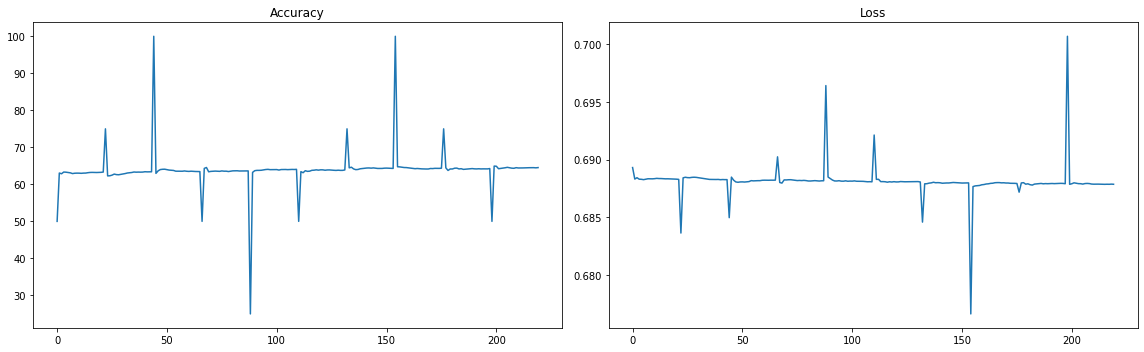

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.plot(acc_step_holder, label="Accuracy")
ax2.plot(loss_step_holder, label="Loss")
ax1.title.set_text("Accuracy")
ax2.title.set_text("Loss")
fig.tight_layout()
plt.show()

## Validation on Test Set

In [11]:
def validate_model(model, testing_loader):
    model.eval()

    n_correct = 0; n_wrong = 0; total = 0;  tr_loss = 0; nb_tr_steps = 0 ; nb_tr_examples = 0;
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0): 
            
            sent_ids = data['sent_ids'].to(device, dtype = torch.long)
            doc_ids = data['doc_ids'].to(device, dtype = torch.long)
            sent_mask = data['sent_mask'].to(device, dtype = torch.long)
            doc_mask = data['doc_mask'].to(device, dtype = torch.long) 
            targets = data['targets'].to(device, dtype = torch.float)  

            outputs = model(sent_ids, doc_ids, sent_mask, doc_mask) 
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            
            n_correct += torch.count_nonzero(targets == (outputs > 0.5)).item()

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%print_n_steps==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples 
                print(str(_* test_params["batch_size"]) + "/" + str(len(train_df)) + " - Steps. Acc ->", accu_step, "Loss ->", loss_step)

             
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [12]:
acc = validate_model(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

0/85354 - Steps. Acc -> 75.0 Loss -> 0.6914950609207153
4000/85354 - Steps. Acc -> 43.70629370629371 Loss -> 0.6949943702418606
8000/85354 - Steps. Acc -> 45.289855072463766 Loss -> 0.6946571803224021
12000/85354 - Steps. Acc -> 45.193268910363216 Loss -> 0.6945400218175515
16000/85354 - Steps. Acc -> 45.32616845788553 Loss -> 0.694449682618284
20000/85354 - Steps. Acc -> 45.410917816436715 Loss -> 0.694458589199137
24000/85354 - Steps. Acc -> 45.72154640893184 Loss -> 0.6943897354545205
28000/85354 - Steps. Acc -> 45.55777746036281 Loss -> 0.6944012894338922
32000/85354 - Steps. Acc -> 45.57242844644419 Loss -> 0.6943892207075366
Validation Loss Epoch: 0.6944062969419691
Validation Accuracy Epoch: 45.45154218097726
Accuracy on test data = 45.45%


Hint: Try a larger sentence embedding [pretrained model](https://www.sbert.net/docs/pretrained_models.html#sentence-embedding-models) to improve overall train/test accuracy. 

## Save Model

In [13]:
import os 

os.makedirs("kaggle/working/models", exist_ok=True)
torch.save(model.state_dict(), "kaggle/working/models/minilm_bal_exsum.pth")

# Conclusions 

The approach described above is a relatively untuned baseline. There are multiple opportunities for improvement. We can discuss a few below:

## Handling Data Imbalance :  
Given the nature of the task (selecting a small subset of sentences in a lengthy document), for most of the sentences we get from our training dataset, the vast majority will not belong to a summary. Class imbalance! 
 In this work, we used undersampling as a baseline strategy to handle class imbalance. A limitation of this approach is that we use a relatively small part of the total available data. We can explore other approaches that enable us to use most or all of our data. Weighted loss functions are recommended! 


## Sentencizer: 
Constructing our training dataset examples depends on the use of a sentencizer that converts documents to sentences which are used in constructing   training examples.  Similarly, at test time, a sentencizer is used to convert documents to sentences which are scored and used in the summary. A poor sentencizer (e.g. one that clips sentences midway) will make for summaries that are hard to read/follow. We found that using a large Spacy language model was a good starting point (the small model is not recommended). Bonus points for investing in a custom sentencizer that incorporates domain knowledge for your problem space. 


## Sentence and Document Representations: 

In this baseline, we use the Sentence Bert small model in deriving representations for sentences and documents. Other methods ( e.g. larger models) etc may provide improved results.  One thing to note is that while BERT based models will yield a representation for an arbitrarily sized document, in practice they are only using the first n tokens (where = maximum sequence length for the model which is usually 512 tokens). We also found that fine tuning the underlying BERT model on the extractive summarization task yielded significantly better results than using the BERT model as a simple feature extractor.


## Tuning Hyperparameters: 

A project like this has many obvious and non-obvious hyperparameters that could all be tuned. Beyond the choice of BERT model architecture and training parameters, we could also tune things like the label generation strategy, sentencizer, minimum sentence length to use in training/inference etc.
